# N-Gram Language Model

### A. Library Tools

In [2]:
import nltk
from nltk.corpus import brown

In [3]:
brown_bigram_cfd = nltk.ConditionalFreqDist(nltk.bigrams(brown.words()))
    # type: dict.
    # structure:
    #  keys = words; values = dict of next_word:frequency.

In [10]:
brown_bigram_cpd = nltk.ConditionalProbDist(brown_bigram_cfd, nltk.MLEProbDist)

In [20]:
brown_bigram_cpd['my'] # 'my' has 1161 next words in total.

<MLEProbDist based on 1161 samples>

In [25]:
brown_bigram_cpd['my'].prob('own') # p(w_i+1=own | w_i=my)

0.04478897502153316

### B. N-Gram LMs

**NB: In practice, GT-smoothing is used with Linear Interpolation (e.g. $\hat(p)(w_n|w_{n-2}w_{n-1}) = \lambda_1p(w_n|w_{n-2}w_{n-1}) + \lambda_2p(w_n|w_{n-1}) + \lambda_3p(w_n)$), where $\lambda$ weights are learned using EM algorithm. This is not implemented here because EM algorithm will be implemented later on.**

In [1]:
import nltk

In [2]:
def load_brown(train_percentage=.8):
    from nltk.corpus import brown
    from nltk.stem import PorterStemmer
    print "... loading sentences"
    brown_sents = brown.sents()
    print "... stemming and lowercasing words"
    brown_sents = [[PorterStemmer().stem(w).lower() for w in sent]
                   for sent in brown_sents]
    print "... padding sentences"
    brown_sents = [['<s>']+s+['</s>'] for s in brown_sents]
    cut_off = int(len(brown_sents)*.8)
    
    return ([w for s in brown_sents[:cut_off] for w in s], \
            brown_sents[cut_off:]) # train: a list of words; test: a list of sents.

In [3]:
%%time
brown_train, brown_test = load_brown()
print brown_train[0]

... loading sentences
... stemming and lowercasing words
... padding sentences
<s>
CPU times: user 21.3 s, sys: 266 ms, total: 21.5 s
Wall time: 21.7 s


In [132]:
import numpy as np
from nltk.util import ngrams
from collections import Counter, defaultdict
from functools import partial
from __future__ import division

In [133]:
from sklearn.linear_model import LinearRegression

In [170]:
class NGramLM:
    
    def __init__(self, train, test, n=2):
        self.train = train # a list of words.
        self.test = test # a list of lists of words (i.e. a list of splitted sents).
        self.n = n
        self.vocab = list(set(train))
        test_vocab = {w for s in self.test for w in s}
        self.unseen_vocab = test_vocab - test_vocab.intersection(set(self.vocab))
        self.N = len(train)
        self.V = len(self.vocab)
        self.build_n_grams()
        
    def build_n_grams(self):
        n_grams = {} 
        N_cs, gt_lrs = {}, {}
            # N_cs: a dictionary of n-gram frequency of frequency (good-turing).
            #  keys: N_cs[2], e.g., for N_c distribution of bigrams.
            # gt_lrs: linear regression: log(N_c) = intercept + coef * log(c).
            #  handles N_c = 0 cases (Gale & Sampson 1995).
            #  keys: gt_lrs[2] returns the function that takes a count c,
            #        and returns an estimated N_c.
        for i in xrange(1,self.n+1):
            n_grams[i] = Counter(ngrams(self.train,i)) 
            N_c = defaultdict(int) # N_c: keys=freq; values=freq of freq.
            for freq in n_grams[i].values():
                N_c[freq] += 1
            N_cs[i] = N_c
            lr = LinearRegression()
            lr.fit(np.log(N_c.keys())[:,np.newaxis],np.log(N_c.values())[:,np.newaxis])
            gt_lrs[i] = lambda c: np.exp(lr.intercept_[0] + lr.coef_[0][0]*np.log(c))
                # log(N_c) = intercept + coef * log(c) =>
                # N_c = exp( intercept + coef * log(c) ) (cf. J&M ch4.5:21,eq.4.29).
        self.n_grams = n_grams
        self.N_cs = N_cs
        self.gt_lrs = gt_lrs             
        
    def adjusted_count(self, ngram, smoothing='laplace'): # ngram: a list of words, e.g. ['my','pencil'].
        n = len(ngram)
        c = self.n_grams[n][tuple(ngram)]
        if smoothing=='laplace':
            c_adjusted = self.laplace_adjust(c)
        else: 
            c_adjusted = self.good_turing_adjust(c,n)      
        return c_adjusted
    
    def laplace_adjust(self, c):
        return (c+1)*(self.N/(self.N+self.V)) # (cf. J&M ch4.5:17,eq.4.21)
    
    def get_N_c(self, c, n):
        N_c = 0 if c not in self.N_cs[n].keys() else self.N_cs[n][c]
            # accessing N_cs[n][c] when it doesn't exist would make a 0 entry at N_cs[n][c],
            #  because N_cs[n] is set as a defaultdict(int) for computational convenience.
        if N_c==0:
            return self.gt_lrs[n](c)
        return N_c
    
    def good_turing_adjust(self, c, n): # n for n in 'n'-gram
        k = 5 # Katz correction (Katz 1987)
        if c==0: 
            N_0 = self.get_N_c(1,n) # N_1 for N_0, moved prob. mass = N_1/N (cf. J&M ch4.5:20,eq.4.25) 
            return N_0 * (1/len(self.unseen_vocab))
                # prob(w_unseen) = (N_1/N)*(1/unseen_vocab_size) = (N_1*(1/unseen_vocab_size)) / N,
                #  so instead of returning N_1 for count, we multiply it by (1/unseen_vocab_size)
                #  as a special case (i.e. 0-count case) treatment.
                #  logically this is returning a count, but computationally it adds up.
        elif c>=1 and c<=k:
            return ( (c+1)*(self.get_N_c(c+1,n)/self.get_N_c(c,n)) / \
                     1 - ( (k+1)*self.get_N_c(k+1,n) ) / self.get_N_c(1,n) ) # (cf. J&M ch4.5:21,eq.4.31)
        else:
            return (c+1)*(self.get_N_c(c+1,n)/self.get_N_c(c,n))
    
    def n_gram_probability(self, sent, n=1, smoothing='laplace'):
        p = 1
        for i in xrange(1,n): # special case handling, e.g, (w_i | w_i-2,w_i-1) = (w_i), etc.
            if i==1:
                p *= self.adjusted_count(sent[:i],smoothing)/self.N
            else:
                p *= self.adjusted_count(sent[:i],smoothing)/self.adjusted_count(sent[:i-1],smoothing)
        n_grams = list(ngrams(sent,n))
        for n_gram in n_grams:
            if n==1:
                p *= self.adjusted_count(n_gram,smoothing)/self.N
            else:
                p *= self.adjusted_count(n_gram,smoothing)/self.adjusted_count(n_gram[:-1],smoothing)
        return p if p>0 else 1e-323 # if still underflow, return the smallest number possible.
    
    def perplexity(self, sent, n=1, smoothing='laplace'):
        N = len(sent)
        p = self.n_gram_probability(sent,n,smoothing)
        return np.exp(-(1/N)*np.log(p))
            # more likely returning np.power(p,-1/N) exposes us to 
            #  underflow issue (cf. J&M ch4.8:26,eq.4.45)
            # np.exp(-(1/N)*np.log(p)) is LESS LIKELY to have this issue.

    def evaluate(self, n=1, smoothing='laplace'):
        return np.mean([self.perplexity(sent,n,smoothing) for sent in self.test])

# smoothing variable passing pipeline:
# 
# perplexity() --> n_gram_probability() --> adjusted_count() 
#     |\        
#     |     
# evaluate() 

In [171]:
%%time
nglm = NGramLM(brown_train,brown_test,n=6)

CPU times: user 7.78 s, sys: 151 ms, total: 7.93 s
Wall time: 7.99 s


##### GT-smoothing has lower average perplexity over ngrams than Laplace-smoothing
**NB: unigram doesn't care about dependency at all, so its perplexity is not a good evaluator for comparing language models.**

**NB: GT-smoothing here doesn't have Linear Interpolation accompany it, so perplexity increases as the size of ngram increases. However the point of this demo is only to show that GT-smoothing has lower avg. perplexity.**

In [173]:
%%time
print 'Laplace Smoothing:'
for i in xrange(2,6+1):
    print '... %d-gram Average Perplexity: %.6f' % (i,nglm.evaluate(n=i,smoothing='laplace'))

Laplace Smoothing:
... 2-gram Average Perplexity: 61.502261
... 3-gram Average Perplexity: 9.536523
... 4-gram Average Perplexity: 4.197516
... 5-gram Average Perplexity: 3.661287
... 6-gram Average Perplexity: 3.602977
CPU times: user 3.41 s, sys: 72.2 ms, total: 3.48 s
Wall time: 3.43 s


In [174]:
%%time
print 'Good-Turing Smoothing:'
for i in xrange(2,6+1):
    print '... %d-gram Average Perplexity: %.6f' % (i,nglm.evaluate(n=i,smoothing='good-turing'))

Good-Turing Smoothing:
... 2-gram Average Perplexity: 1.138796
... 3-gram Average Perplexity: 1.716055
... 4-gram Average Perplexity: 1.499161
... 5-gram Average Perplexity: 1.884957
... 6-gram Average Perplexity: 2.056255
CPU times: user 24.7 s, sys: 812 ms, total: 25.5 s
Wall time: 24.9 s


##### Demo: How GT-smoothing with Linear Regression works

In [144]:
print nglm.N_cs[6] # key=freq (for 6-grams); value=freq of freq.

defaultdict(<type 'int'>, {1: 1035401, 2: 9414, 3: 1720, 4: 647, 5: 347, 6: 180, 7: 154, 8: 69, 9: 38, 10: 35, 11: 34, 12: 15, 13: 26, 14: 23, 15: 10, 16: 17, 17: 6, 18: 8, 19: 12, 20: 7, 21: 2, 22: 4, 23: 2, 24: 3, 25: 3, 26: 2, 27: 2, 29: 3, 30: 2, 31: 1, 32: 1, 33: 1, 34: 5, 35: 1, 36: 3, 37: 3, 38: 2, 40: 2, 43: 1, 44: 2, 49: 3, 51: 1, 52: 1, 53: 2, 55: 1, 63: 1, 164: 1})


In [145]:
c_vec = nglm.N_cs[6].keys() 
N_c_vec = nglm.N_cs[6].values() 
print c_vec
print N_c_vec

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 43, 44, 49, 51, 52, 53, 55, 63, 164]
[1035401, 9414, 1720, 647, 347, 180, 154, 69, 38, 35, 34, 15, 26, 23, 10, 17, 6, 8, 12, 7, 2, 4, 2, 3, 3, 2, 2, 3, 2, 1, 1, 1, 5, 1, 3, 3, 2, 2, 1, 2, 3, 1, 1, 2, 1, 1, 1]


In [146]:
import matplotlib.pyplot as plt
%matplotlib inline

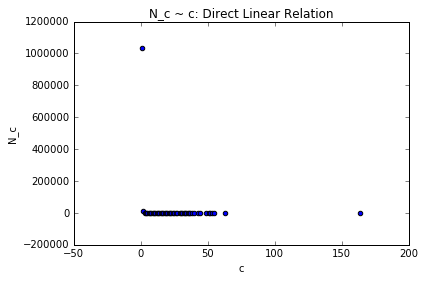

In [147]:
plt.scatter(c_vec,N_c_vec)
plt.title('N_c ~ c: Direct Linear Relation')
plt.xlabel('c')
plt.ylabel('N_c')

In [150]:
log_c_vec, log_N_c_vec = np.log(c_vec), np.log(N_c_vec)
lr = LinearRegression()
lr.fit(log_c_vec[:,np.newaxis],log_N_c_vec[:,np.newaxis])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

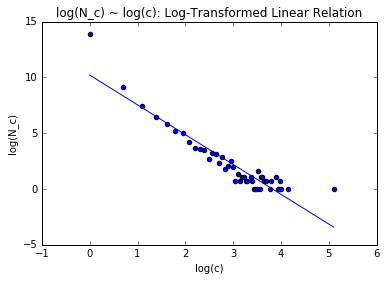

In [156]:
plt.scatter(log_c_vec,log_N_c_vec)
plt.plot(log_c_vec, map(lambda log_c:lr.intercept_[0]+lr.coef_[0][0]*log_c, log_c_vec))
plt.title('log(N_c) ~ log(c): Log-Transformed Linear Relation')
plt.xlabel('log(c)')
plt.ylabel('log(N_c)')

##### Why Perplexity? (ref. Hockenmaier, U Illinois, CS498JH: Lec 4, pp8-10)

* **Cross Entropy**

    * Equation: 
        * Cross Entropy Approx: $H(p,m) = lim_{n\to\infty}-\frac{1}{n}\sum_{w_1...w_n}p(w_1...w_n)log_2m(w_1...w_n) \simeq -\frac{1}{N}log_2m(w_1...w_N)$ (by *Shannon-McMillan-Breiman Theorem*).
        * Actual Entropy: $H(p) = lim_{n\to\infty}-\frac{1}{n}\sum_{w_1...w_n}p(w_1...w_n)log_2p(w_1...w_n) \simeq -\frac{1}{N}log_2p(w_1...w_N)$
    
    * Notation: $p$ is the true distribution (in the context of language model, the probability distribution that spits out word sequences) and $m$ is the model distribution. $N$ is the size of a (training) corpus.
    
    * Meaning: $H(p,m)$ indicates the average number of bits required to encode messages sampled from $p$ with a coding scheme based on $m$ (in this context, again, it means generating word sequences using $m$, as an approximation to the word sequences generated by the true distribution $p$.

* **Perplexity**

    * $Perplexity(w_1...w_N) = 2^{H(w_1...w_N)} = 2^{-\frac{1}{N}log2m(w_1...w_N)} = m(w_1...w_N)^{-\frac{1}{N}} = \sqrt[N]{\frac{1}{m(w_1...w_N)}}$.

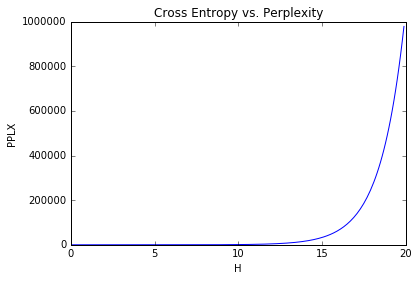

In [184]:
# CROSS ENT VS. PERPLEXITY PLOT
def frange(x,y,step):
    while x < y:
        yield x
        x += step
H = [i for i in frange(0,20,.1)]
plt.plot(H,np.power(2,H))
plt.title('Cross Entropy vs. Perplexity')
plt.xlabel('H')
plt.ylabel('PPLX')

# Part-Of-Speech Tagging

* ** Task **

    * $P(t|w)$, i.e. given a word (i.e. observation), what is its POS tag (i.e. generator)?
    * More generally, $P(\mathbf{t}|\mathbf{w})$, i.e. given a word sequence, what is the most likely tag sequence?

* ** Most-Likely Tag Sequence **

    * Equation: $\hat{\mathbf{t}} = argmax_\mathbf{t}P(\mathbf{t}|\mathbf{w}) \simeq argmax_\mathbf{t}\prod_{i=1}^nP(w_i|t_i)P(t_i|t_{i-1})$ (for derivation, cf. J&M ch5.5:18-19).
        * $P(w_i|t_i) = \frac{C(t_i,w_i)}{C(t_i)}$ (cf. J&M ch5.5:20,eq.5.34).
        * $P(t_i|t_{i-1}) = \frac{C(t_{i-1},t_i)}{C(t_{i-1})}$ (cf. ibid.,eq.5.32).
    * Assumptions:
        * The appearance of a word only depends on its POS tag (i.e. independent of words around it).
        * The appearance of a tag only depends on its previous tag.
        
* ** Optimization Goal **
    
    * Given a chart representation such as the following (cf. J&M ch5.5:27,fig.5.18), find the best tag sequence (*Viterbi Algorithm*).

### A. HMM (Optimization = Viberbi Algorithm)

* ** HMM Formalism ** (cf. J&M ch5.5:23)

    * $Q = q_1...q_N$, a set of $N$ *states*.
    * $A = a_{11}a_{12}...a_{nn}$, where $\sum_{j=1}^na_{ij} = 1, \forall i$, a *transition probability matrix* $A$.
    * $O = o_1...o_T$, a sequence of *observations*.
    * $B = b_i(o_t)$, a sequence of *emission probabilities* (i.e. the probability of an observation $o_t$ being omitted at state $i$.
    * $q_0,q_F$, *start state* and *end state*.

##### Toy Viterbi

In [189]:
# q_end  end     end     end     end     end
#
# q_4    NN      NN      NN      NN      NN
#
# q_3    TO      TO      TO      TO      TO
#
# q_2    VB      VB      VB      VB      VB
# 
# q_1    PPSS    PPSS    PPSS    PPSS    PPSS
#
# q_0    <s>     <s>     <s>     <s>     <s>
#
#                w_1      w2      w3      w4      <== Observable

In [190]:
import numpy as np

In [230]:
Q = {1:'PPSS',2:'VB',3:'TO',4:'NN'}
A = np.array([[0.,    .67,    .019,    .0043,    .041],   # rows: from-states, cols: to-states.
              [0.,    .00013, .23,     .00079,   .0012],  # rows=cols={START,PPSS,VB,TO,NN}, len=5
              [0.,    .007,   .0038,   .035,     .047],   # e.g. A[3][2] = p(TO->VB) = .83.
              [0.,    0.,     .83,     0.,       .00047],  
              [0.,    .0045,  .004,    .016,     .087]])
O = {1:'i',2:'want',3:'to',4:'race'}
B = np.array([[1.,     0.,     0.,     0.,     0.],     # rows: emitting-state, cols: emitted-observations.
              [0.,     .37,    0.,     0.,     0.],     #  rows={START,PPSS,VB,TO,NN}, len=5
              [0.,     0.,     .0093,  0.,     .00012], #  cols={<s>,i,want,to,race}, len=5  
              [0.,     0.,     0.,     .99,    0.],     # e.g. B[1][1] = p(PPSS->i) = .37. 
              [0.,     0.,     .000054,0.,     .00057]])  
# Q[0], Q['F']
HMM = {'Q':Q, 'A':A, 'O':O, 'B':B}

In [324]:
def toy_viterbi():
    N, T = len(Q), len(O) # 4, 4
    viterbi = np.zeros((N+2,T+1)) # 6x5, 2 extra rows for start & end, 1 extra col for time_0.
    backpointer = np.zeros((N+2,T+1),dtype=int) # dtype=int: np matrix defaults float.
    for s in xrange(1,N+1): # from 1 to N.
        viterbi[s][1] = A[0][s] * B[s][1]
        backpointer[s][1] = 0
    for t in xrange(2,T+1): # from 2 to T.
        for s in xrange(1,N+1): # from 1 to N. 
            viterbi[s][t] = max(viterbi[s_prime][t-1]*A[s_prime][s]*B[s][t]
                                        for s_prime in xrange(1,N+1))
            backpointer[s][t] = np.argmax([viterbi[s_prime][t-1]*A[s_prime][s]
                                           for s_prime in xrange(1,N+1)])+1 # we are indexing from 1
                                                                            # python starts from 0.
    max_state = np.argmax(viterbi[:,N])
    best_tagged_seq = []
    for s in reversed(xrange(1,N+1)): # backtracing backpointer's cols: 4->1.
        best_tagged_seq.insert(0,(O[s],Q[max_state])) 
        max_state = backpointer[max_state][s]
        
    return best_tagged_seq 
    

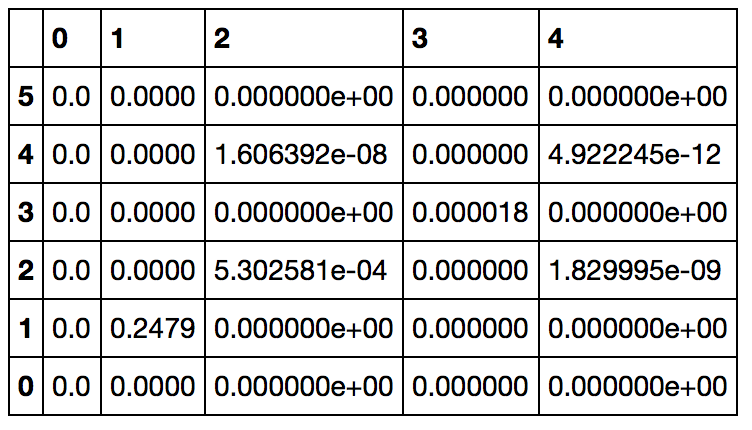

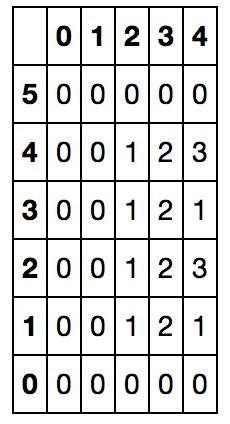

In [322]:
from IPython.display import Image, display
display(Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NLP/FIGS/toy_viterbi_viterbi.png',width='30%'))
display(Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NLP/FIGS/toy_viterbi_backpointer.png',width='10%'))

** Dummy's Guide to Backtracing **

* Set up most-likely-sequence container (MLS): [] (NB: insert to the beginning of the container).
* At Viterbi matrix's last column (end-state, 4), found the max is 1.83e-09, at index 2. MLS = [2].
* Go to Backpointer matrix's last column (col=4), found col[2] is 3. MLS = [3,2].
* In Backpointer matrix's previous column (col=3), found col[3] is 2. MLS = [2,3,2].
* In Backpointer matrix's previous column (col=2), found col[2] is 1. MLS = [1,2,3,2].
* Stop at the beginning of the backtracing (col=1), which points to 0.

In [325]:
MLS = toy_viterbi()
print MLS

[('i', 'PPSS'), ('want', 'VB'), ('to', 'TO'), ('race', 'VB')]
